In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

Using TensorFlow backend.


* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [4]:
import sqlite3

conn = sqlite3.connect('database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Data Cleaning


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [0]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [6]:
from tqdm import tqdm
import re

pre_processed = []

i = 0
N = len(data['Text'])
for sentence in tqdm(data['Text'], ncols=80):    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 

    pre_processed.append(sentence)

data['Text'] = pre_processed

100%|████████████████████████████████| 524607/524607 [00:09<00:00, 56602.18it/s]


In [0]:
sentiment = []

for scr in data['Score']:
    if scr < 3:
        sentiment.append(0)
    else:
        sentiment.append(1)
data['Sentiment'] = sentiment

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,1
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,i can remember seeing the show when it aired o...,1
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuice is a well written movie ever...,1
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,a twist of rumplestiskin captured on film sta...,1
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,a twist of rumplestiskin captured on film sta...,1


### Data Segmentation

* Considered 300k data for processing.
* Then data is divided in 70-30 ratio for training and testing purposes.
* Data is divided according to time.

In [0]:
te = int(30000 * 7)
X_train = data['Text'][0:te]
Y_train = data['Sentiment'][0:te]
X_test = data['Text'][te:300000]
Y_test = data['Sentiment'][te:300000]

In [10]:
print("shape of training data: ", X_train.shape)
print("shape of testing data: ", X_test.shape)

shape of training data:  (210000,)
shape of testing data:  (90000,)


### Tokenization

Converting each word to respective index number in vocabulary

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 4000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=1000)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=1000)

In [12]:
print("shape of training data: ", X_train.shape)
print("shape of testing data: ", X_test.shape)

shape of training data:  (210000, 1000)
shape of testing data:  (90000, 1000)


# Model

In [0]:
embed_length = 150

model = Sequential()
model.add(Embedding(max_features, embed_length, input_length=X_train.shape[1]))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 150)         600000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 700,501
Trainable params: 700,501
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
nb_epoch = 7
history = model.fit(X_train, Y_train, epochs=nb_epoch, batch_size=512, 
                    verbose=2)

Epoch 1/7
 - 1118s - loss: 0.2180 - acc: 0.9183
Epoch 2/7
 - 1048s - loss: 0.1461 - acc: 0.9456
Epoch 3/7
 - 1046s - loss: 0.1227 - acc: 0.9552
Epoch 4/7
 - 1046s - loss: 0.1053 - acc: 0.9622
Epoch 5/7
 - 1047s - loss: 0.0910 - acc: 0.9680
Epoch 6/7
 - 1046s - loss: 0.0785 - acc: 0.9728
Epoch 7/7
 - 1048s - loss: 0.0696 - acc: 0.9762


In [1]:
%matplotlib notebook
def plt_dynamic(x, ty, ax, colors=['b']):
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Test score: 0.181762033148
Test accuracy: 0.937477777778


<IPython.core.display.Javascript object>


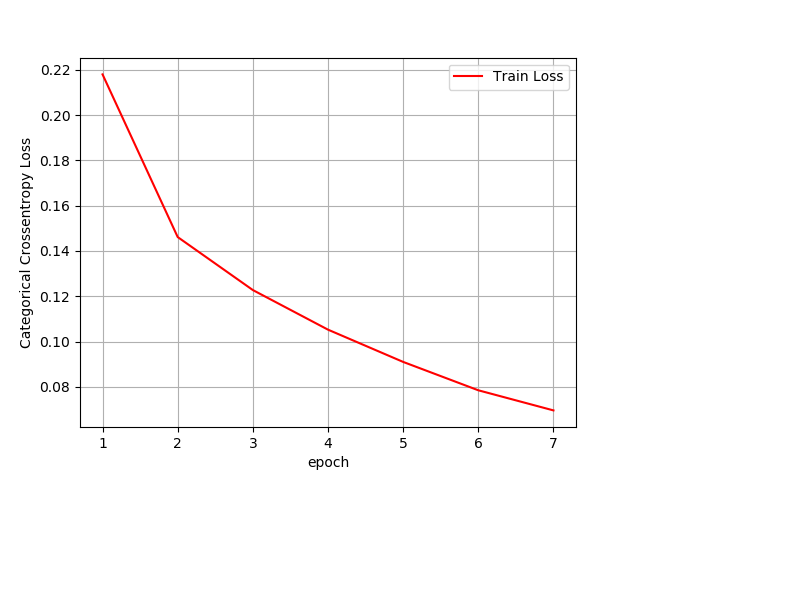

In [0]:
import matplotlib.pyplot as plt

score = model.evaluate(X_test, Y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,nb_epoch+1))

ty = history.history['loss']
plt_dynamic(x, ty, ax)

In [0]:
performence = []
performence.append(["Single-Layer LSTM", 0.9762, 0.181762, 0.937477])

# Model

In [16]:
embed_length = 150

model = Sequential()
model.add(Embedding(max_features, embed_length, input_length=X_train.shape[1]))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 150)         600000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 100)         100400    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 780,901
Trainable params: 780,901
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=512, 
                   verbose=1)

Epoch 1/5
210000/210000 [==============================] - 2585s 12ms/step - loss: 0.2126 - acc: 0.9202
Epoch 2/5
210000/210000 [==============================] - 2619s 12ms/step - loss: 0.1429 - acc: 0.9472
Epoch 3/5
210000/210000 [==============================] - 2584s 12ms/step - loss: 0.1195 - acc: 0.9568
Epoch 4/5
210000/210000 [==============================] - 2579s 12ms/step - loss: 0.0984 - acc: 0.9657
Epoch 5/5
210000/210000 [==============================] - 2526s 12ms/step - loss: 0.0869 - acc: 0.9705


In [24]:
import matplotlib.pyplot as plt

score = model.evaluate(X_test, Y_test, batch_size=512, verbose=1) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

90000/90000 [==============================] - 401s 4ms/step
Test score: 0.17458735286659666
Test accuracy: 0.9334111112276713


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
history.history['loss']

[0.2126250130460376,
 0.14287984361875625,
 0.11951803707168215,
 0.09840294739972977,
 0.08694182541143326]

In [2]:
loss = [0.2126250130460376, 0.14287984361875625, 0.11951803707168215, 
        0.09840294739972977, 0.08694182541143326]

<IPython.core.display.Javascript object>


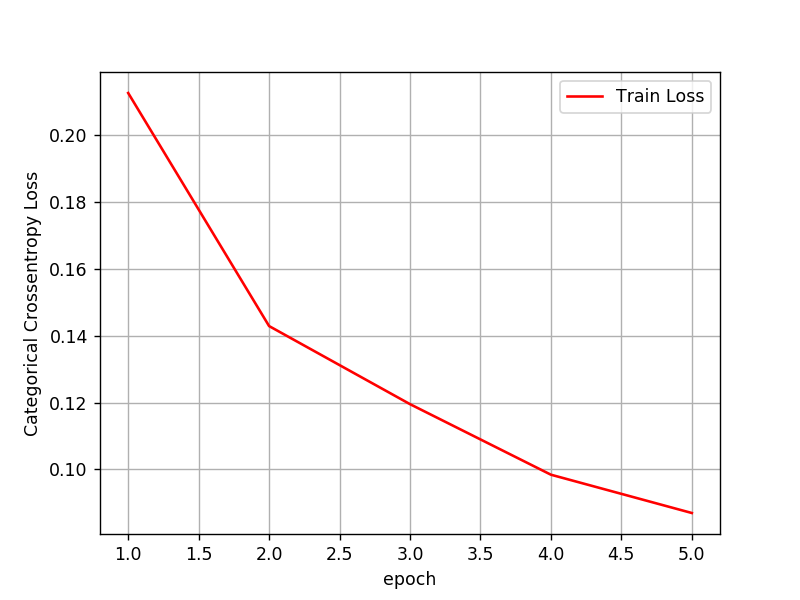

In [3]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,6))

plt_dynamic(x, loss, ax)

In [0]:
performence.append(["Two-Layer LSTM", 0.9705, score[0], score[1]])

In [38]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Network", "Train Accuracy", "Test Score", "Test Accuracy"]
table.add_row(performence[0])
table.add_row(performence[1])

print(table)

+-------------------+----------------+---------------------+--------------------+
|      Network      | Train Accuracy |      Test Score     |   Test Accuracy    |
+-------------------+----------------+---------------------+--------------------+
| Single-Layer LSTM |     0.9762     |       0.181762      |      0.937477      |
|   Two-Layer LSTM  |     0.9705     | 0.17458735286659666 | 0.9334111112276713 |
+-------------------+----------------+---------------------+--------------------+
